In [1]:
import lancedb

In [2]:
def get_metadata_value(table, key_name, value_column="value"):
    """
    Retrieves a single value from a LanceDB table given a key.

    Args:
        table: The opened LanceDB table object.
        key_name: The string key to look for (e.g., 'tbl_img_emb').
        value_column: The name of the column containing the data.
    """
    # Filter for the key and select only the necessary column
    result = table.search().where(f"key='{key_name}'").select([value_column]).to_pandas()

    if not result.empty:
        return result[value_column].iloc[0]
    return None

In [3]:
# Path where your config DB lives
embedding_db_path = "/glade/work/ncheruku/research/bams-ai-data-exploration/data/lancedb/experiments/era5"
source_img_path = "/glade/work/ncheruku/research/bams-ai-data-exploration/data/lancedb/shared_source"
# Name of your config table
project_name = "dinov3"
src_img_tbl_name = "era5_sample_images"

# Connect and open table
db = lancedb.connect(embedding_db_path)
source_db = lancedb.connect(source_img_path)
config_tbl = db.open_table(project_name + "_config")
img_emb_tbl = db.open_table(get_metadata_value(config_tbl, "img_emb_table_current"))
patch_emb_tbl = db.open_table(get_metadata_value(config_tbl, "patch_emb_table_current"))
src_img_tbl = source_db.open_table(src_img_tbl_name)

# patch_emb_tbl.count_rows()

In [4]:
src_img_tbl.schema

# patch_emb_tbl= db.open_table(get_metadata_value(config_tbl, "patch_emb_table_current"))

id: string
filename: string
dt: timestamp[s]
image_blob: binary
thumb_blob: binary
-- schema metadata --
dataset_info: '{"dataset_name": "ERA5 Hurricane Training Data (RGB Compos' + 1339
version: '1.0'

In [5]:
patch_emb_tbl.schema

patch_id: string
image_id: string
patch_index: int32
embedding: fixed_size_list<item: float>[768]
  child 0, item: float

In [6]:
img_emb_tbl.schema

image_id: string
embedding: fixed_size_list<item: float>[768]
  child 0, item: float

In [7]:
config_tbl.schema

key: string
value: string

image size: (256, 256)
patch_index: 135


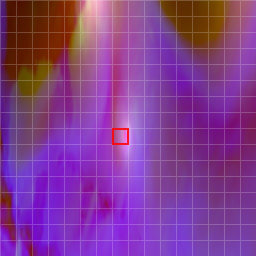

In [18]:
import io

from PIL import Image, ImageDraw

FILENAME = "20161009_rgb.jpeg"
PATCH_SIZE = 16
IMG_SIZE = 256
DRAW_GRID = True


def fetch_image_by_filename(src_img_tbl, filename: str):
    """Load image from src_img_tbl using filename instead of id."""
    row = src_img_tbl.search().where(f"filename = '{filename}'").limit(1).to_pandas().iloc[0]
    return Image.open(io.BytesIO(row["image_blob"])).convert("RGBA")


def overlay_grid(img: Image.Image, patch_size: int = PATCH_SIZE, color=(255, 255, 255, 50), width: int = 1) -> Image.Image:
    w, h = img.size
    overlay = Image.new("RGBA", img.size, (0, 0, 0, 0))
    d = ImageDraw.Draw(overlay)

    for x in range(0, w + 1, patch_size):
        d.line([(x, 0), (x, h)], fill=color, width=width)
    for y in range(0, h + 1, patch_size):
        d.line([(0, y), (w, y)], fill=color, width=width)

    return Image.alpha_composite(img, overlay)


def patch_box_from_index(patch_index: int, img_w: int = IMG_SIZE, img_h: int = IMG_SIZE, patch_size: int = PATCH_SIZE):

    grid_w = img_w // patch_size
    grid_h = img_h // patch_size
    n_patches = grid_w * grid_h

    if patch_index < 0 or patch_index >= n_patches:
        raise ValueError(f"patch_index {patch_index} out of range [0, {n_patches - 1}]")

    row = patch_index // grid_w
    col = patch_index % grid_w

    x0 = col * patch_size
    y0 = row * patch_size
    x1 = x0 + patch_size
    y1 = y0 + patch_size
    return (x0, y0, x1, y1)


def highlight_patch(img: Image.Image, box, fill=(255, 0, 0, 0), outline=(255, 0, 0, 220), outline_width: int = 2) -> Image.Image:

    overlay = Image.new("RGBA", img.size, (0, 0, 0, 0))
    d = ImageDraw.Draw(overlay)
    d.rectangle(box, fill=fill, outline=outline, width=outline_width)
    return Image.alpha_composite(img, overlay)


#  Load image by FILENAME (not id)
img = fetch_image_by_filename(src_img_tbl, FILENAME)
print("image size:", img.size)

# Optional sanity check
if img.size != (IMG_SIZE, IMG_SIZE):
    print(f"WARNING: expected {(IMG_SIZE, IMG_SIZE)} but got {img.size}")

# Create visualization image
img_vis = img
if DRAW_GRID:
    img_vis = overlay_grid(img_vis, PATCH_SIZE)

# Choose a patch to highlight
patch_index = 135

print("patch_index:", patch_index)

# Highlight patch
box = patch_box_from_index(patch_index, IMG_SIZE, IMG_SIZE, PATCH_SIZE)
img_hl = highlight_patch(img_vis, box)
img_hl

In [19]:
image_id = src_img_tbl.search().where(f"filename = '{FILENAME}'").select(["id"]).limit(1).to_pandas().iloc[0]["id"]

q = (
    patch_emb_tbl.search()
    .where(f"image_id = '{image_id}' AND patch_index = {patch_index}")
    .select(["patch_id", "image_id", "patch_index", "embedding"])
    .limit(1)
    .to_pandas()
    .iloc[0]
)

query_emb = q["embedding"]

top_df = patch_emb_tbl.search(query_emb).metric("cosine").select(["patch_id", "image_id", "patch_index"]).limit(100).to_pandas()

top_df

[2026-02-12T18:44:20Z WARN  lance::dataset::scanner] Deprecation warning, this behavior will change in the future. This search specified output columns but did not include `_distance`.  Currently the `_distance` column will be included.  In the future it will not.  Call `disable_scoring_autoprojection` to to adopt the future behavior and avoid this warning


,patch_id,image_id,patch_index,_distance
0,25b6148b9c01b274d128679adcabc940:135,25b6148b9c01b274d128679adcabc940,135,89.363281
1,25b6148b9c01b274d128679adcabc940:184,25b6148b9c01b274d128679adcabc940,184,89.676346
2,25b6148b9c01b274d128679adcabc940:118,25b6148b9c01b274d128679adcabc940,118,89.914787
3,25b6148b9c01b274d128679adcabc940:136,25b6148b9c01b274d128679adcabc940,136,90.175537
4,88e05f6a2b795a59ecf226773e813762:42,88e05f6a2b795a59ecf226773e813762,42,90.341881
...,...,...,...,...
95,ef51815ddedfff4c885253ba70bea349:65,ef51815ddedfff4c885253ba70bea349,65,91.726372
96,2e491c164731b76cf12e801d15c27486:57,2e491c164731b76cf12e801d15c27486,57,91.728882
97,84c8deb0b9a4accca19b76789a5ff10e:57,84c8deb0b9a4accca19b76789a5ff10e,57,91.732201
98,25b6148b9c01b274d128679adcabc940:38,25b6148b9c01b274d128679adcabc940,38,91.735680


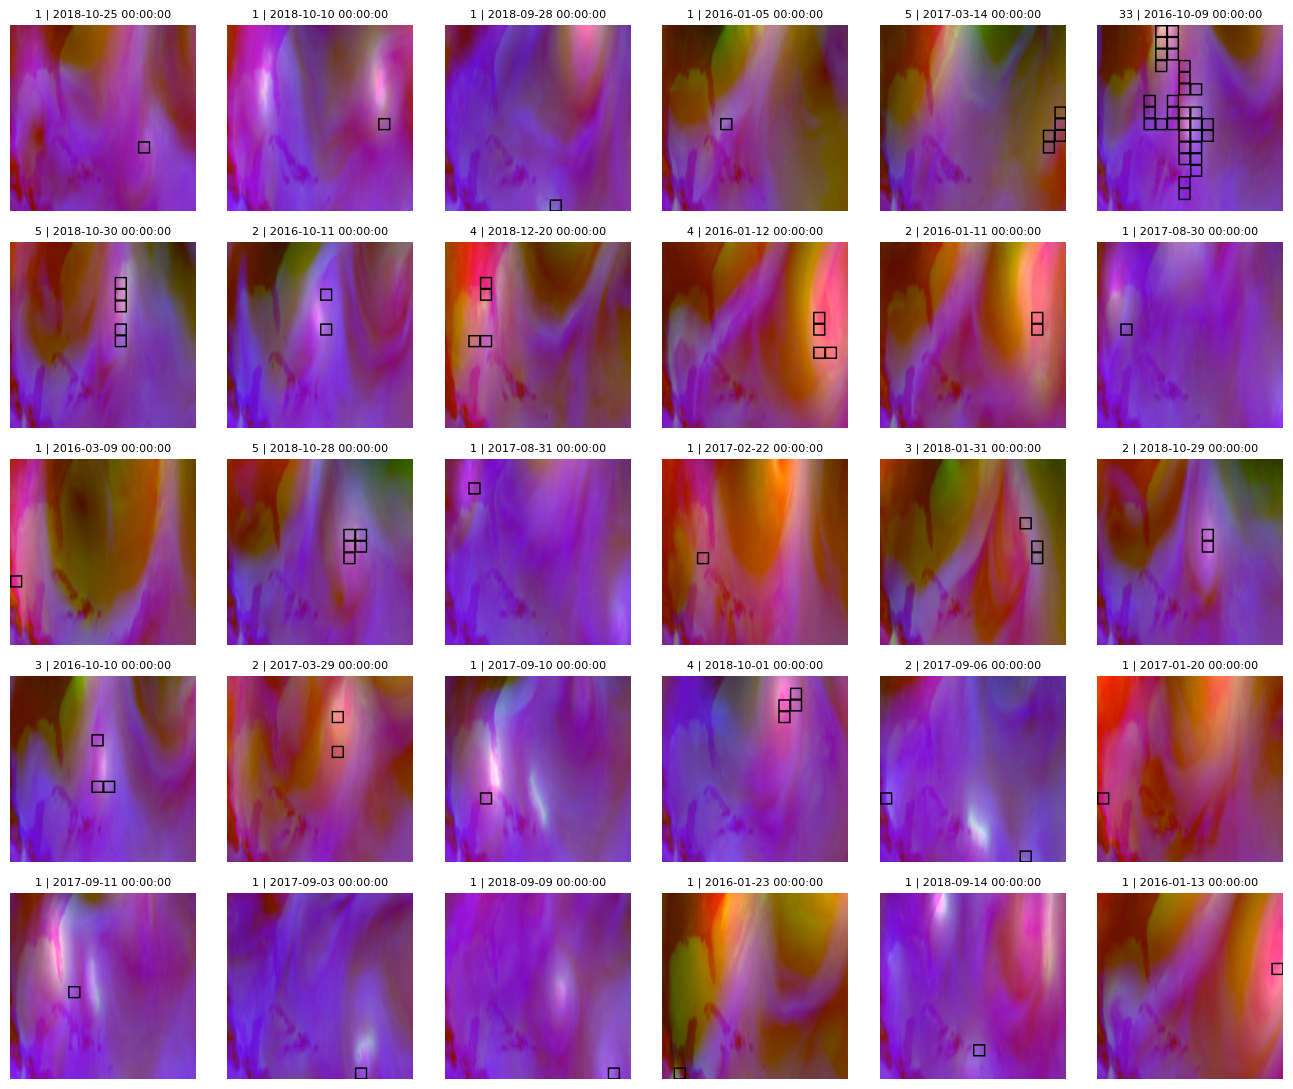

,image_id,dt,n_patches,patch_indices
0,02f6f4be7da7b5c765fd8e65c43335d4,2018-10-25,1,[171]
1,068bf2d9eebdc6a59ab3b581f78a2649,2018-10-10,1,[141]
2,089b78586901b6638164198d95366ade,2018-09-28,1,[249]
3,09001b9e34aeb786697e06ec31b6297b,2016-01-05,1,[133]
4,12438a90b2f2216040e918e6d62d8b58,2017-03-14,5,"[143, 159, 158, 127, 174]"
5,25b6148b9c01b274d128679adcabc940,2016-10-09,33,"[135, 184, 118, 136, 53, 151, 21, 152, 37, 167..."
6,2e491c164731b76cf12e801d15c27486,2018-10-30,5,"[121, 73, 89, 137, 57]"
7,31e9d44ba872dfe4a062cabccf4e2f4f,2016-10-11,2,"[120, 72]"
8,3e0d055fa2cd3546609c274351af9d22,2018-12-20,4,"[131, 51, 67, 130]"
9,44874dba6f8edf80eb2f7e7ff44550a5,2016-01-12,4,"[158, 109, 125, 157]"


In [20]:
import math

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

PATCH, BASE = 16, 256

# group matches by image_id; keep up to 30 unique images
u = top_df.groupby("image_id")["patch_index"].apply(list).head(30)

thumbs, rows = [], []
for img_id, pidxs in u.items():
    r = src_img_tbl.search().where(f"id = '{img_id}'").select(["image_blob", "dt"]).limit(1).to_pandas().iloc[0]

    im = Image.open(io.BytesIO(r["image_blob"])).convert("RGB")
    tw, th = im.size
    sx, sy = tw / BASE, th / BASE
    grid_w = BASE // PATCH

    d = ImageDraw.Draw(im)
    for pidx in map(int, pidxs):
        rr, cc = pidx // grid_w, pidx % grid_w
        x0, y0 = cc * PATCH, rr * PATCH
        box = (int(x0 * sx), int(y0 * sy), int((x0 + PATCH) * sx), int((y0 + PATCH) * sy))
        d.rectangle(box, outline=(0, 0, 0), width=max(2, int(round(min(sx, sy)))))

    thumbs.append(im)
    rows.append({"image_id": img_id, "dt": r["dt"], "n_patches": len(pidxs), "patch_indices": pidxs})

dates_df = pd.DataFrame(rows)

n = len(thumbs)
cols = min(6, n)
rows_n = math.ceil(n / cols)
plt.figure(figsize=(cols * 2.2, rows_n * 2.2))
for i, im in enumerate(thumbs, 1):
    ax = plt.subplot(rows_n, cols, i)
    ax.imshow(im)
    ax.set_title(f"{dates_df.loc[i - 1, 'n_patches']} | {str(dates_df.loc[i - 1, 'dt'])[:19]}", fontsize=8)
    ax.axis("off")
plt.tight_layout()
plt.show()

dates_df